In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score


In [2]:
#  ---------------------------
# CONFIG / HYPERPARAMETERS
# ---------------------------
DATA_DIR = "./dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
EPOCHS = 20
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Transfer learning specific settings
INITIAL_EPOCHS = 5  # Epochs with frozen base
FINE_TUNE_EPOCHS = 10  # Additional epochs for fine-tuning
FINE_TUNE_AT = 100  # Unfreeze layers from this index onwards

  # Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [3]:
# ---------------------------
# DATA LOADERS
# ---------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Prefetch for performance
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 46564 files belonging to 2 classes.
Found 13304 files belonging to 2 classes.
Found 6653 files belonging to 2 classes.


In [4]:
# Compute class counts for class weights
def compute_class_weights(dataset):
    counts = np.array([0,0], dtype=np.int64)
    for _, labels in dataset.unbatch().batch(1024):
        lab = labels.numpy().astype(int)
        unique, c = np.unique(lab, return_counts=True)
        for u, cnt in zip(unique, c):
            counts[u] += cnt
    total = counts.sum()
    class_weight = {0: total / (2 * counts[0]) if counts[0] > 0 else 1.0,
                    1: total / (2 * counts[1]) if counts[1] > 0 else 1.0}
    return class_weight, counts

class_weight, counts = compute_class_weights(train_ds)
print("Training class counts:", counts, "Class weights:", class_weight)

Training class counts: [25221 21343] Class weights: {0: 0.9231196225367749, 1: 1.0908494588389637}


In [5]:
# ---------------------------
# DATA AUGMENTATION
# ---------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.05),
    layers.RandomTranslation(0.03, 0.03),
    layers.RandomContrast(0.08),
], name="data_augmentation")

In [6]:
# ---------------------------
# BUILD TRANSFER LEARNING MODEL
# ---------------------------
def build_transfer_model(input_shape=(*IMG_SIZE, 3), trainable_base=False):
    """
    Build a transfer learning model using ResNet50.

    Args:
        input_shape: Input image shape
        trainable_base: Whether to make the base model trainable
    """
    inputs = layers.Input(shape=input_shape)

    # Data augmentation (only applied during training)
    x = data_augmentation(inputs)

    # Preprocessing for ResNet50 (rescale to [-1, 1])
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Load pre-trained ResNet50 (without top classification layer)
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'  # Global average pooling
    )

    # Freeze base model initially
    base_model.trainable = trainable_base

    # Add base model
    x = base_model(x, training=False)

    # Add custom classification head
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="resnet50_transfer")

    return model, base_model

# Build model with frozen base
model, base_model = build_transfer_model(trainable_base=False)
model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "resnet50_transfer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
__________________________________________________

In [7]:
# ---------------------------
# COMPILE MODEL
# ---------------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),  # Higher LR for frozen base
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

In [8]:
# ---------------------------
# PHASE 1: TRAIN WITH FROZEN BASE
# ---------------------------
print("\n" + "="*50)
print("PHASE 1: Training with frozen ResNet50 base")
print("="*50 + "\n")

checkpoint_path = os.path.join(MODEL_DIR, "best_resnet50_frozen.h5")
cb_checkpoint = callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)
cb_early = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
cb_reduce = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    class_weight=class_weight,
    callbacks=[cb_checkpoint, cb_early, cb_reduce]
)


PHASE 1: Training with frozen ResNet50 base

Epoch 1/5
728/728 [==============================] - 239s 288ms/step - loss: 0.5164 - accuracy: 0.7372 - precision: 0.7077 - recall: 0.7269 - auc: 0.8191 - val_loss: 0.3929 - val_accuracy: 0.8080 - val_precision: 0.8283 - val_recall: 0.7332 - val_auc: 0.9008

Epoch 00001: val_auc improved from -inf to 0.90075, saving model to models\best_resnet50_frozen.h5


C:\MyPrograms\Anaconda\envs\tf_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
728/728 [==============================] - 195s 267ms/step - loss: 0.4100 - accuracy: 0.8037 - precision: 0.7930 - recall: 0.7738 - auc: 0.8889 - val_loss: 0.3627 - val_accuracy: 0.8347 - val_precision: 0.8714 - val_recall: 0.7501 - val_auc: 0.9092

Epoch 00002: val_auc improved from 0.90075 to 0.90924, saving model to models\best_resnet50_frozen.h5
Epoch 3/5
728/728 [==============================] - 199s 273ms/step - loss: 0.3734 - accuracy: 0.8228 - precision: 0.8191 - recall: 0.7873 - auc: 0.9083 - val_loss: 0.3412 - val_accuracy: 0.8299 - val_precision: 0.8044 - val_recall: 0.8309 - val_auc: 0.9275

Epoch 00003: val_auc improved from 0.90924 to 0.92745, saving model to models\best_resnet50_frozen.h5
Epoch 4/5
728/728 [==============================] - 199s 273ms/step - loss: 0.3526 - accuracy: 0.8328 - precision: 0.8351 - recall: 0.7915 - auc: 0.9181 - val_loss: 0.3399 - val_accuracy: 0.8272 - val_precision: 0.7881 - val_recall: 0.8521 - val_auc: 0.9251

Epoch 00004: val

In [9]:
model.save("best_resnet50_frozen.h5")

In [10]:
# ---------------------------
# PHASE 2: FINE-TUNING
# ---------------------------
print("\n" + "="*50)
print("PHASE 2: Fine-tuning ResNet50")
print("="*50 + "\n")

# Unfreeze the base model
base_model.trainable = True

# Freeze layers before FINE_TUNE_AT
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

print(f"Number of layers in base model: {len(base_model.layers)}")
print(f"Number of trainable layers after unfreezing: {sum([1 for layer in base_model.layers if layer.trainable])}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Much lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

checkpoint_path_ft = os.path.join(MODEL_DIR, "best_resnet50_finetuned.h5")
cb_checkpoint_ft = callbacks.ModelCheckpoint(
    checkpoint_path_ft,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)
cb_early_ft = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=6,
    restore_best_weights=True,
    verbose=1
)
cb_reduce_ft = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-8
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history_frozen.epoch[-1],
    class_weight=class_weight,
    callbacks=[cb_checkpoint_ft, cb_early_ft, cb_reduce_ft]
)

# Save final model
model.save(os.path.join(MODEL_DIR, "resnet50_final.h5"))


PHASE 2: Fine-tuning ResNet50

Number of layers in base model: 176
Number of trainable layers after unfreezing: 76
Epoch 5/15
728/728 [==============================] - 194s 249ms/step - loss: 0.2415 - accuracy: 0.8876 - precision: 0.8909 - recall: 0.8601 - auc: 0.9627 - val_loss: 0.2619 - val_accuracy: 0.8782 - val_precision: 0.8314 - val_recall: 0.9210 - val_auc: 0.9629

Epoch 00005: val_auc improved from -inf to 0.96285, saving model to models\best_resnet50_finetuned.h5
Epoch 6/15
728/728 [==============================] - 180s 247ms/step - loss: 0.1763 - accuracy: 0.9209 - precision: 0.9145 - recall: 0.9127 - auc: 0.9807 - val_loss: 0.1593 - val_accuracy: 0.9248 - val_precision: 0.9118 - val_recall: 0.9254 - val_auc: 0.9834

Epoch 00006: val_auc improved from 0.96285 to 0.98343, saving model to models\best_resnet50_finetuned.h5
Epoch 7/15
728/728 [==============================] - 181s 249ms/step - loss: 0.1486 - accuracy: 0.9344 - precision: 0.9240 - recall: 0.9337 - auc: 0.9862 

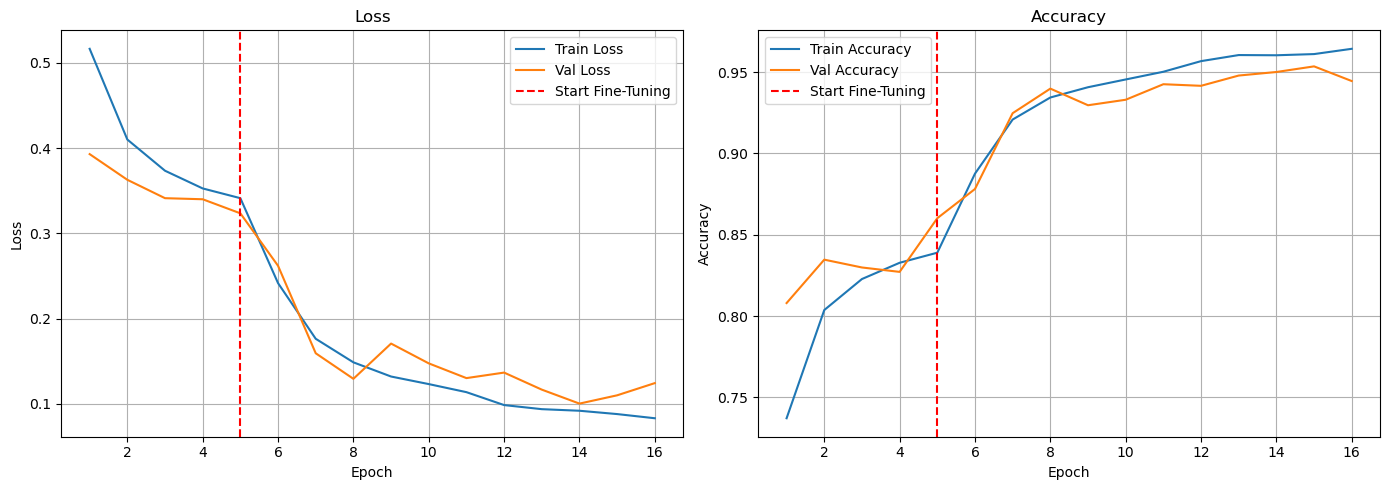

In [11]:
# ---------------------------
# PLOT TRAINING CURVES
# ---------------------------
def plot_training_history(history_frozen, history_finetune, out_path="resnet50_training_curves.png"):
    # Combine histories
    acc = history_frozen.history['accuracy'] + history_finetune.history['accuracy']
    val_acc = history_frozen.history['val_accuracy'] + history_finetune.history['val_accuracy']
    loss = history_frozen.history['loss'] + history_finetune.history['loss']
    val_loss = history_frozen.history['val_loss'] + history_finetune.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.axvline(x=len(history_frozen.history['loss']), color='r', linestyle='--', label='Start Fine-Tuning')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.axvline(x=len(history_frozen.history['accuracy']), color='r', linestyle='--', label='Start Fine-Tuning')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

plot_training_history(history_frozen, history_finetune,
                     out_path=os.path.join(MODEL_DIR, "resnet50_training_curves.png"))


TEST SET RESULTS - ResNet50 Transfer Learning

              precision    recall  f1-score   support

         0.0     0.9662    0.9348    0.9502      3603
         1.0     0.9258    0.9613    0.9432      3050

    accuracy                         0.9469      6653
   macro avg     0.9460    0.9480    0.9467      6653
weighted avg     0.9477    0.9469    0.9470      6653


Confusion Matrix:
[[3368  235]
 [ 118 2932]]

ROC AUC: 0.9922
F1 Score: 0.9432


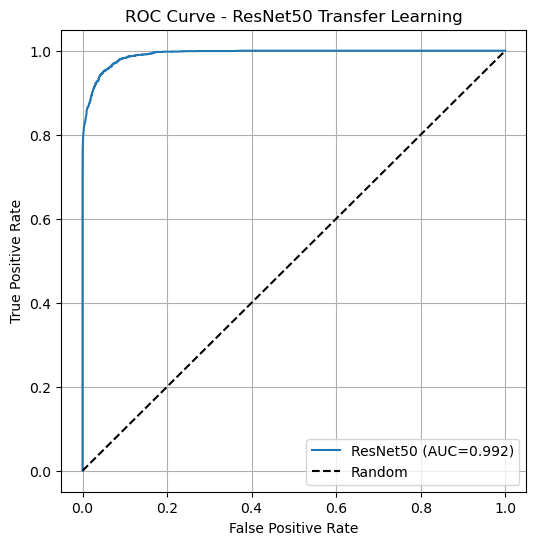


Best model saved to: models\best_resnet50_finetuned.h5


In [12]:
# ---------------------------
# EVALUATE ON TEST SET
# ---------------------------
y_true = []
y_pred_prob = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0).ravel()
    y_pred_prob.extend(probs.tolist())
    y_true.extend(labels.numpy().tolist())

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Metrics
print("\n" + "="*50)
print("TEST SET RESULTS - ResNet50 Transfer Learning")
print("="*50 + "\n")
print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)
auc = roc_auc_score(y_true, y_pred_prob)
print(f"\nROC AUC: {auc:.4f}")
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.4f}")

# Plot ROC curve
fpr, tpr, th = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ResNet50 (AUC={auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet50 Transfer Learning')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(MODEL_DIR, "resnet50_roc_curve.png"))
plt.show()

# Save predictions
np.savez(os.path.join(MODEL_DIR, "resnet50_test_predictions.npz"),
         y_true=y_true, y_pred=y_pred, y_pred_prob=y_pred_prob)

print("\nBest model saved to:", checkpoint_path_ft)